# Import

In [23]:
import tensorflow as tf
import argparse
import os
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Definition of the Architecture

In [2]:
# Following Hinton-Salakhutdinov Architecture

# 3 hidden layers for encoder
n_encoder_h_1 = 1000
n_encoder_h_2 = 500
n_encoder_h_3 = 250

# 3 hidden layers for decoder
n_decoder_h_1 = 250
n_decoder_h_2 = 500
n_decoder_h_3 = 1000

# Parameters
learning_rate = 0.01
training_epochs = 200
batch_size = 100
display_step = 1

# Batch Normalization 

In [3]:
def layer_batch_normalization(x, n_out, phase_train):
    """
    Defines the network layers
    input:
        - x: input vector of the layer
        - n_out: integer, depth of input maps - number of sample in the batch 
        - phase_train: boolean tf.Varialbe, true indicates training phase
    output:
        - batch-normalized maps   
    
    
    """

    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    #tf.nn.moment: https://www.tensorflow.org/api_docs/python/tf/nn/moments
    #calculate mean and variance of x
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    
    #tf.train.ExponentialMovingAverage:
    #https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage
    #Maintains moving averages of variables by employing an exponential decay.
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
        
    #tf.cond: https://www.tensorflow.org/api_docs/python/tf/cond
    #Return true_fn() if the predicate pred is true else false_fn()
    mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))

    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    
    return tf.reshape(normed, [-1, n_out])

# Definition of the Layer 

In [4]:
def layer(x, weight_shape, bias_shape, phase_train):
    
    """
    Defines the network layers
    input:
        - x: input vector of the layer
        - weight_shape: shape the the weight maxtrix
        - bias_shape: shape of the bias vector
        - phase_train: boolean tf.Varialbe, true indicates training phase
    output:
        - output vector of the layer after the matrix multiplication and non linear transformation
    """
    
    #initialize weights
    weight_init = tf.random_normal_initializer(stddev=(1.0/weight_shape[0])**0.5)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    
    bias_init = tf.constant_initializer(value=0)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)

    logits = tf.matmul(x, W) + b
    
    #apply the non-linear function after the batch normalization
    return tf.nn.sigmoid(layer_batch_normalization(logits, weight_shape[1], phase_train))

# Definition of the Encoder Part

In [5]:
def encoder(x, n_code, phase_train):
    
    """
    Defines the network encoder part
    input:
        - x: input vector of the encoder
        - n_code: number of neurons in the code layer (output of the encoder - input of the decoder)
        - phase_train: boolean tf.Varialbe, true indicates training phase
    output:
        - output vector: reduced dimension
    """
    
    with tf.variable_scope("encoder"):
        
        with tf.variable_scope("h_1"):
            h_1 = layer(x, [784, n_encoder_h_1], [n_encoder_h_1], phase_train)

        with tf.variable_scope("h_2"):
            h_2 = layer(h_1, [n_encoder_h_1, n_encoder_h_2], [n_encoder_h_2], phase_train)

        with tf.variable_scope("h_3"):
            h_3 = layer(h_2, [n_encoder_h_2, n_encoder_h_3], [n_encoder_h_3], phase_train)

        with tf.variable_scope("code"):
            output = layer(h_3, [n_encoder_h_3, n_code], [n_code], phase_train)

    return output

# Definition of the Decoder Part

In [6]:
def decoder(x, n_code, phase_train):
    """
    Defines the network encoder part
    input:
        - x: input vector of the decoder - reduced dimension vector
        - n_code: number of neurons in the code layer (output of the encoder - input of the decoder) 
        - phase_train: boolean tf.Variablle, true indicates training phase
    output:
        - output vector: reconstructed dimension of the initial vector
    """
    
    with tf.variable_scope("decoder"):
        
        with tf.variable_scope("h_1"):
            h_1 = layer(x, [n_code, n_decoder_h_1], [n_decoder_h_1], phase_train)

        with tf.variable_scope("h_2"):
            h_2 = layer(h_1, [n_decoder_h_1, n_decoder_h_2], [n_decoder_h_2], phase_train)

        with tf.variable_scope("h_3"):
            h_3 = layer(h_2, [n_decoder_h_2, n_decoder_h_3], [n_decoder_h_3], phase_train)

        with tf.variable_scope("output"):
            output = layer(h_3, [n_decoder_h_3, 784], [784], phase_train)

    return output

# Definition of the Loss

In [7]:
def loss(output, x):
    """
    Compute the loss of the auto-encoder
    
    intput:
        - output: the output of the decoder
        - x: true value of the sample batch - this is the input of the encoder
        
        the two have the same shape (batch_size * num_of_classes)
    output:
        - loss: loss of the corresponding batch (scalar tensor)
    
    """
    
    with tf.variable_scope("training"):
        
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x)), 1))
        train_loss = tf.reduce_mean(l2)
        train_summary_op = tf.summary.scalar("train_cost", train_loss)
        return train_loss, train_summary_op

# Training Function

In [8]:
def training(cost, global_step):
    """
    defines the necessary elements to train the network
    
    intput:
        - cost: the cost is the loss of the corresponding batch
        - global_step: number of batch seen so far, it is incremented by one 
        each time the .minimize() function is called
    """
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

# Evaluation Function

In [9]:
def evaluate(output, x):
    """
    evaluates the accuracy on the validation set 
    input:
        -output: prediction vector of the network for the validation set
        -x: true value for the validation set
    output:
        - val_loss: loss of the autoencoder
        - in_image_op: input image 
        - out_image_op:reconstructed image 
        - val_summary_op: summary of the loss
    """
    
    with tf.variable_scope("validation"):
        
        in_image_op = image_summary("input_image", x)
        
        out_image_op = output
        
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        
        val_loss = tf.reduce_mean(l2_norm)
        
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
        
        return val_loss, in_image_op, output, val_summary_op

# Image Summary

In [10]:
def image_summary(label, tensor):
    #tf.summary.image: https://www.tensorflow.org/api_docs/python/tf/summary/image
    #Outputs a Summary protocol buffer with images.

    tensor_reshaped = tf.reshape(tensor, [-1, 28, 28, 1])
    return tf.summary.image(label, tensor_reshaped)

# Main Function

In [11]:
import numpy as np
def next_batch(data,labels,batchSize):
    #Return a total of ‘batchSize‘ random samples
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batchSize]
    data_shuffle = np.array([data[i] for i in idx])
    label_shuffle = np.array([labels[i] for i in idx])
    return data_shuffle,label_shuffle

In [12]:
if __name__ == '__main__':

    #if a python file, please use the 4 lines bellow and comment the "n_code = '1'"
    #parser = argparse.ArgumentParser(description='Autoencoder')
    #parser.add_argument('n_code', nargs=1, type=str)
    #args = parser.parse_args(['--help'])
    #n_code = args.n_code[0]
    
    #if a jupyter file, please comment the 4 above and use the one bellow
    n_code = '2'
    
    #feel free to change with your own 
    log_files_path = 'C:/Users/Ali/logs/'

    with tf.Graph().as_default():

        with tf.variable_scope("autoencoder_model"):

            #the input variables are first define as placeholder 
            # a placeholder is a variable/data which will be assigned later 
            # image vector & label, phase_train is a boolean 
            x = tf.placeholder("float", [None, 784]) # MNIST data image of shape 28*28=784
            
            phase_train = tf.placeholder(tf.bool)
            
            #define the encoder 
            code = encoder(x, int(n_code), phase_train)
            
            #define the decoder
            output = decoder(code, int(n_code), phase_train)
            
            #compute the loss 
            cost, train_summary_op = loss(output, x)

            #initialize the value of the global_step variable 
            # recall: it is incremented by one each time the .minimise() is called
            global_step = tf.Variable(0, name='global_step', trainable=False)

            train_op = training(cost, global_step)

            #evaluate the accuracy of the network (done on a validation set)
            eval_op, in_image_op, out_image_op, val_summary_op = evaluate(output, x)

            summary_op = tf.summary.merge_all()

            #save and restore variables to and from checkpoints.
            saver = tf.train.Saver(max_to_keep=200)

            #defines a session
            sess = tf.Session()

            # summary writer
            #https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter
            train_writer = tf.summary.FileWriter(log_files_path + 'mnist_autoencoder_hidden_' + n_code + '_logs/', graph=sess.graph)

            val_writer   = tf.summary.FileWriter(log_files_path + 'mnist_autoencoder_hidden_' + n_code + '_logs/', graph=sess.graph)

            #initialization of the variables
            init_op = tf.global_variables_initializer()

            sess.run(init_op)

            # Training cycle
            for epoch in range(training_epochs):

                avg_cost = 0.
                total_batch = int(mnist.train.num_examples/batch_size)
                
                # Loop over all batches
                for i in range(total_batch):
                    
                    minibatch_x, minibatch_y = next_batch(mnist.train.images,mnist.train.labels,batch_size)
                    
                    # Fit training using batch data
                    #the training is done using the training dataset
                    _, new_cost, train_summary = sess.run([train_op, cost, train_summary_op], feed_dict={x: minibatch_x, phase_train: True})
                    
                    train_writer.add_summary(train_summary, sess.run(global_step))
                    
                    # Compute average loss
                    avg_cost += new_cost/total_batch
                
                # Display logs per epoch step
                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost))

                    #the accuracy is evaluated using the validation dataset
                    train_writer.add_summary(train_summary, sess.run(global_step))

                    validation_loss, in_image, out_image, val_summary = sess.run([eval_op, in_image_op, out_image_op, val_summary_op], feed_dict={x: mnist.validation.images, phase_train: False})
#                     val_writer.add_summary(in_image, sess.run(global_step))
#                     val_writer.add_summary(out_image, sess.run(global_step))
#                     val_writer.add_summary(val_summary, sess.run(global_step))
                    print("Validation Loss:", validation_loss)
#                     print (out_image)
                    #save to use later
                    #https://www.tensorflow.org/api_docs/python/tf/train/Saver
                    #saver.save(sess, log_files_path+'model-checkpoint', global_step=global_step)
                    saver.save(sess, log_files_path + 'mnist_autoencoder_hidden_' + n_code + '_logs/model-checkpoint-' + '%04d' % (epoch+1), global_step=global_step)


            print("Optimization Finished!")

            test_loss = sess.run(eval_op, feed_dict={x: mnist.test.images, phase_train: False})

            print("Test Loss:", test_loss)

('Epoch:', '0001', 'cost =', '11.407961537')
('Validation Loss:', 9.671574)
('Epoch:', '0002', 'cost =', '9.380851947')
('Validation Loss:', 8.652035)
('Epoch:', '0003', 'cost =', '8.338354625')
('Validation Loss:', 7.7865415)
('Epoch:', '0004', 'cost =', '7.738336594')
('Validation Loss:', 7.167214)
('Epoch:', '0005', 'cost =', '7.313517166')
('Validation Loss:', 6.9313045)
('Epoch:', '0006', 'cost =', '7.018869923')
('Validation Loss:', 6.6640096)
('Epoch:', '0007', 'cost =', '6.812001191')
('Validation Loss:', 6.5993032)
('Epoch:', '0008', 'cost =', '6.632904234')
('Validation Loss:', 6.6748643)
('Epoch:', '0009', 'cost =', '6.500066818')
('Validation Loss:', 6.219827)
('Epoch:', '0010', 'cost =', '6.342213203')
('Validation Loss:', 6.1930814)
('Epoch:', '0011', 'cost =', '6.082663245')
('Validation Loss:', 5.924226)
('Epoch:', '0012', 'cost =', '5.972418535')
('Validation Loss:', 5.8927913)
('Epoch:', '0013', 'cost =', '5.921537966')
('Validation Loss:', 5.8279753)
('Epoch:', '0014

('Validation Loss:', 4.9957952)
('Epoch:', '0110', 'cost =', '5.092931432')
('Validation Loss:', 4.9999638)
('Epoch:', '0111', 'cost =', '5.096907541')
('Validation Loss:', 4.9997773)
('Epoch:', '0112', 'cost =', '5.083269517')
('Validation Loss:', 5.0067787)
('Epoch:', '0113', 'cost =', '5.085005439')
('Validation Loss:', 4.979644)
('Epoch:', '0114', 'cost =', '5.079602943')
('Validation Loss:', 5.005178)
('Epoch:', '0115', 'cost =', '5.084962549')
('Validation Loss:', 5.012705)
('Epoch:', '0116', 'cost =', '5.079026103')
('Validation Loss:', 4.988306)
('Epoch:', '0117', 'cost =', '5.073567523')
('Validation Loss:', 5.0448494)
('Epoch:', '0118', 'cost =', '5.072142842')
('Validation Loss:', 4.979096)
('Epoch:', '0119', 'cost =', '5.074318487')
('Validation Loss:', 5.0161295)
('Epoch:', '0120', 'cost =', '5.073056249')
('Validation Loss:', 4.973151)
('Epoch:', '0121', 'cost =', '5.066904920')
('Validation Loss:', 4.9615808)
('Epoch:', '0122', 'cost =', '5.071223581')
('Validation Loss:

In [13]:
validation_loss, in_image, out_image, val_summary = sess.run([eval_op, in_image_op, out_image_op, val_summary_op], feed_dict={x: mnist.train.images[:5000], phase_train: False})


In [34]:
encoder_images =  out_image

# Generating samples from auto-encoders

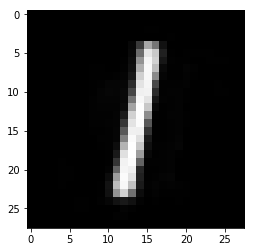

In [37]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.imshow(encoder_images[4].reshape(28,28), cmap='gray')
plt.show()

# GAN 

In [38]:
#MNIST data image of shape 28*28=784
#mnist_size = 784
X = tf.placeholder(tf.float32, shape=[None, 784])
Z = tf.placeholder(tf.float32, shape=[None, 100])

# Set up parameters for generator and discriminator

In [39]:
# Generator
# Define the variables for the generator, we will use them to build layers later
# -------------------
size_g_w1 = 100
size_g_b1 = 128
# A good way to decide the std for initializing the weights
w1_std = 1.0/tf.sqrt(size_g_w1/2.0)

G_W1 = tf.Variable(tf.random_normal(shape=[size_g_w1, size_g_b1], stddev=w1_std))
G_b1 = tf.Variable(tf.zeros(shape=[size_g_b1]))

size_g_w2 = 128
size_g_b2 = 784
w2_std = 1.0/tf.sqrt(size_g_w2/2.0)

G_W2 = tf.Variable(tf.random_normal(shape=[size_g_w2, size_g_b2], stddev=w2_std))
G_b2 = tf.Variable(tf.zeros(shape=[size_g_b2]))
# theta_G and theta_D will be feeded to different optimizers later as "var_list", 
# since currently we have two networks instead of one now.
theta_G = [G_W1, G_W2, G_b1, G_b2]

# ====================
# Discriminator
# Define the variables for the discriminator
# --------------------
size_d_w1 = 784
size_d_b1 = 128
w1_std = 1.0/tf.sqrt(size_d_w1/2.0)

D_W1 = tf.Variable(tf.random_normal(shape=[size_d_w1,size_d_b1], stddev=w1_std))
D_b1 = tf.Variable(tf.zeros(shape=[size_d_b1]))

size_d_w2 = 128
size_d_b2 = 1
w2_std = 1.0/tf.sqrt(size_d_w2/2.0)

D_W2 = tf.Variable(tf.random_normal(shape=[size_d_w2,size_d_b2], stddev=w2_std))
D_b2 = tf.Variable(tf.zeros(shape=[size_d_b2]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

In [40]:
def generator(z):

    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_logit)

    return G_prob, G_logit

def discriminator(x):

    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [41]:
def sample_z(m, n):
    # randomly generate samples for generator
    return np.random.uniform(-1.0, 1.0, size = [m, n])

In [42]:
def plot_sample(samples, size1, size2):
    
    fig1 = plt.figure(figsize=(size1, size2))
    gs = gridspec.GridSpec(size1, size2)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='gray')

    return fig1

In [43]:
# Though it's not possible to get the path to the notebook by __file__, os.path is still very useful in dealing with paths and files
# In this case, we can use an alternative: pathlib.Path
"""
code_dir   = os.path.dirname(__file__)
"""

code_dir = '/home/shayaan/Columbia/sem_1/Deep-Learning-for-OR-and-FE/assign4'

print code_dir
#create output_dir within the same path
output_dir = code_dir+'/outputGANs_temp/'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

/home/shayaan/Columbia/sem_1/Deep-Learning-for-OR-and-FE/assign4


In [44]:
# Put randomly generated sample Z into the generator to create "fake" images
G_sample, _ = generator(Z)
# The result of discriminator of real and fake samples
_, D_logit_real = discriminator(X)
_, D_logit_fake = discriminator(G_sample)

# generator loss 
# the goal of generator is to let discriminator make more mistakes on fake samples
# tf.ones_like returns a tensor with all elements set to 1
# 0 represent fake and 1 means real
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

# discriminator loss 
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)

In [51]:
def generate_data(data):
    images = np.concatenate((data,encoder_images),axis=0)
    return images
    

In [52]:
def next_batch(data, batchSize):
    #Return a total of ‘batchSize‘ random samples
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batchSize]
    data_shuffle = np.array([data[i] for i in idx])
    return data_shuffle

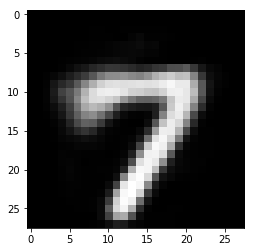

iteration: 0
D_loss: 1.48
G_loss: 2.475
()


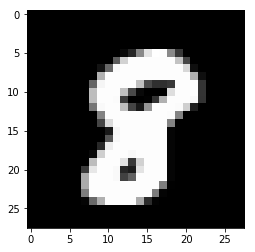

iteration: 1000
D_loss: 0.01991
G_loss: 6.419
()


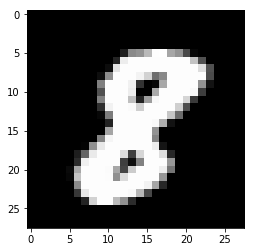

iteration: 2000
D_loss: 0.01617
G_loss: 6.129
()


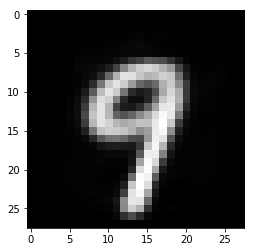

iteration: 3000
D_loss: 0.1341
G_loss: 5.276
()


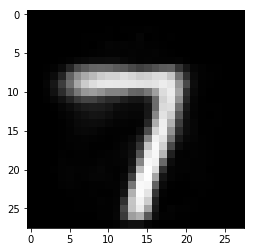

iteration: 4000
D_loss: 0.3171
G_loss: 5.171
()


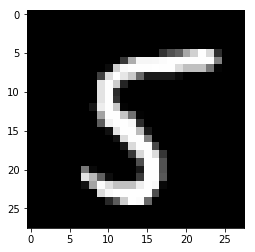

iteration: 5000
D_loss: 0.2301
G_loss: 5.34
()


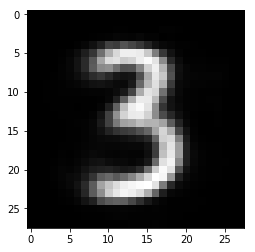

iteration: 6000
D_loss: 0.3942
G_loss: 3.776
()


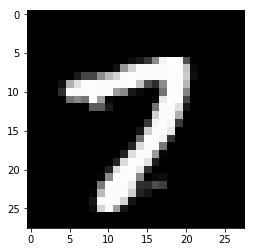

iteration: 7000
D_loss: 0.6001
G_loss: 4.125
()


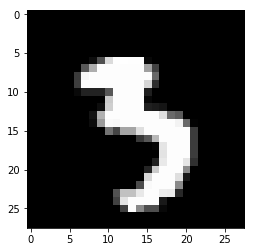

iteration: 8000
D_loss: 0.7871
G_loss: 4.009
()


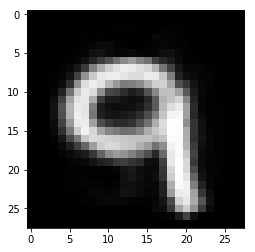

iteration: 9000
D_loss: 0.6252
G_loss: 3.31
()


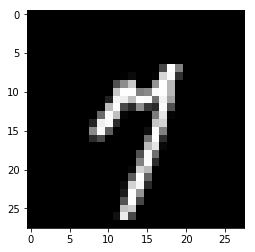

iteration: 10000
D_loss: 0.7426
G_loss: 2.586
()


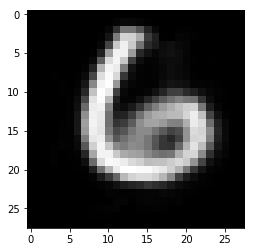

iteration: 11000
D_loss: 0.6017
G_loss: 3.837
()


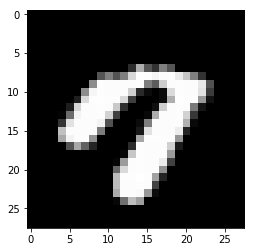

iteration: 12000
D_loss: 0.9056
G_loss: 2.669
()


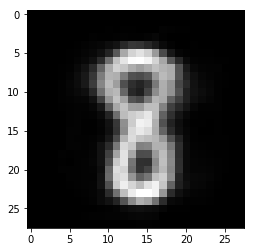

iteration: 13000
D_loss: 0.7832
G_loss: 2.805
()


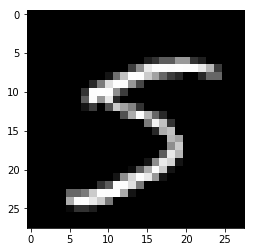

iteration: 14000
D_loss: 0.7026
G_loss: 2.539
()


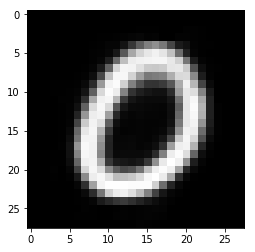

iteration: 15000
D_loss: 0.8778
G_loss: 2.485
()


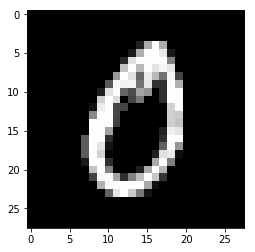

iteration: 16000
D_loss: 0.8827
G_loss: 2.876
()


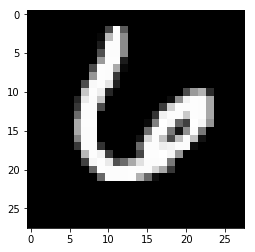

iteration: 17000
D_loss: 1.015
G_loss: 2.322
()


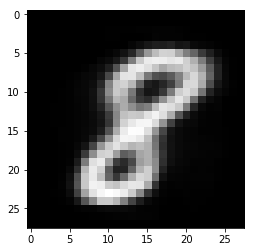

iteration: 18000
D_loss: 0.961
G_loss: 2.657
()


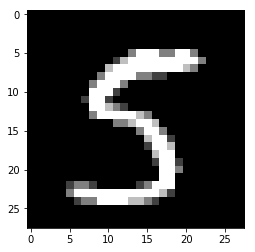

iteration: 19000
D_loss: 0.7554
G_loss: 2.662
()


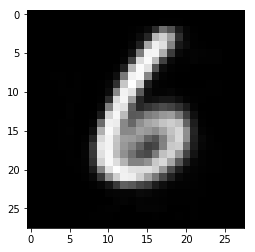

iteration: 20000
D_loss: 0.9006
G_loss: 2.907
()


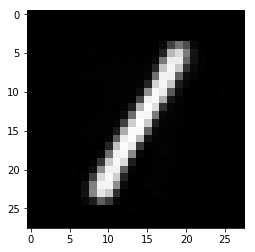

iteration: 21000
D_loss: 0.7535
G_loss: 2.381
()


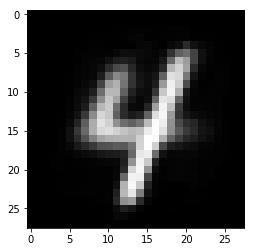

iteration: 22000
D_loss: 1.082
G_loss: 1.757
()


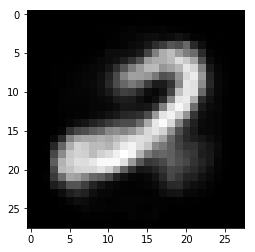

iteration: 23000
D_loss: 0.9378
G_loss: 2.148
()


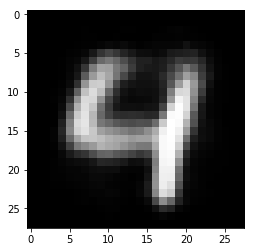

iteration: 24000
D_loss: 0.7956
G_loss: 2.426
()


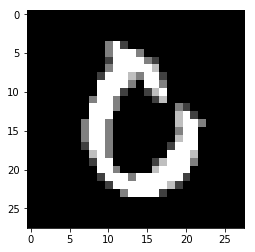

iteration: 25000
D_loss: 0.7955
G_loss: 2.088
()


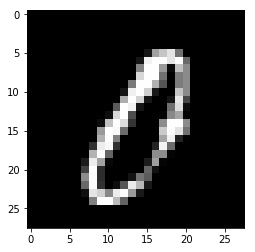

iteration: 26000
D_loss: 1.002
G_loss: 1.976
()


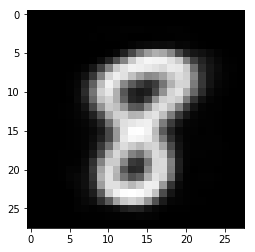

iteration: 27000
D_loss: 0.984
G_loss: 1.849
()


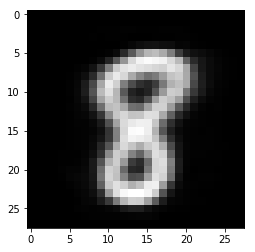

iteration: 28000
D_loss: 0.7322
G_loss: 2.332
()


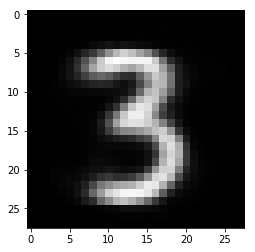

iteration: 29000
D_loss: 0.8509
G_loss: 2.133
()


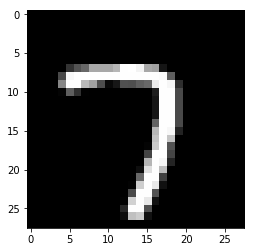

iteration: 30000
D_loss: 0.8745
G_loss: 2.087
()


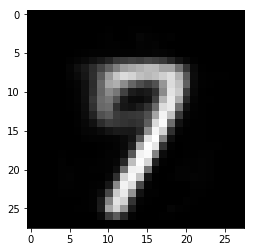

iteration: 31000
D_loss: 0.6516
G_loss: 1.957
()


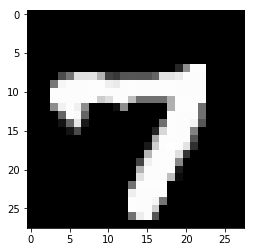

iteration: 32000
D_loss: 0.8662
G_loss: 1.995
()


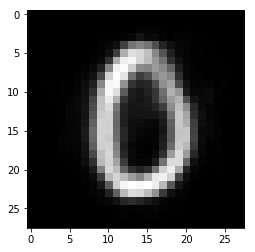

iteration: 33000
D_loss: 1.063
G_loss: 1.958
()


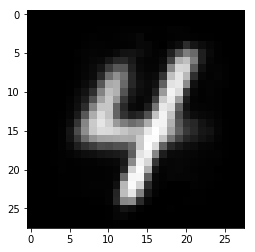

iteration: 34000
D_loss: 0.7455
G_loss: 2.047
()


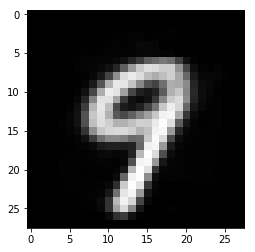

iteration: 35000
D_loss: 0.9089
G_loss: 2.21
()


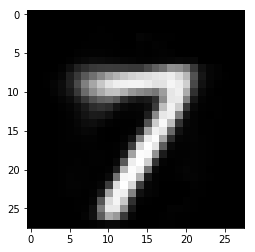

iteration: 36000
D_loss: 0.8083
G_loss: 2.271
()


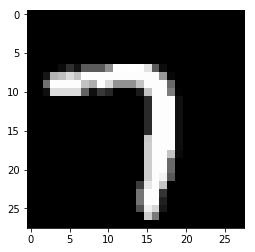

iteration: 37000
D_loss: 0.8935
G_loss: 2.147
()


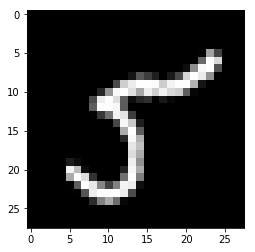

iteration: 38000
D_loss: 1.282
G_loss: 1.479
()


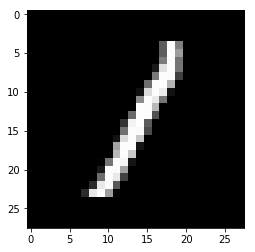

iteration: 39000
D_loss: 1.12
G_loss: 2.437
()


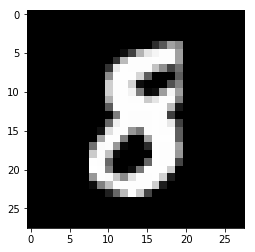

iteration: 40000
D_loss: 1.053
G_loss: 1.632
()


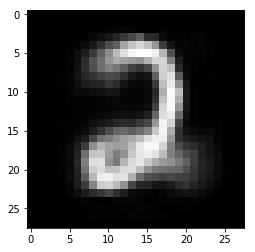

iteration: 41000
D_loss: 0.9285
G_loss: 1.54
()


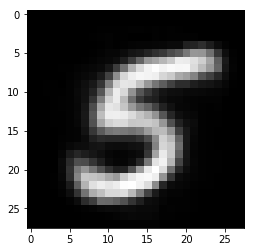

iteration: 42000
D_loss: 0.968
G_loss: 1.457
()


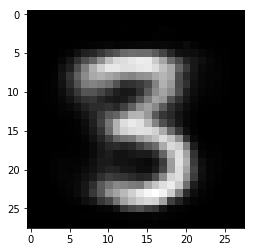

iteration: 43000
D_loss: 0.7843
G_loss: 1.932
()


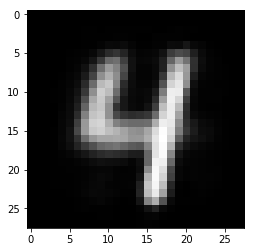

iteration: 44000
D_loss: 1.07
G_loss: 1.82
()


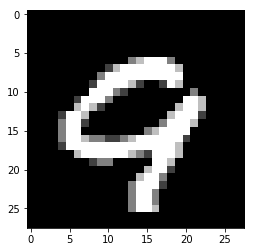

iteration: 45000
D_loss: 0.7235
G_loss: 1.95
()


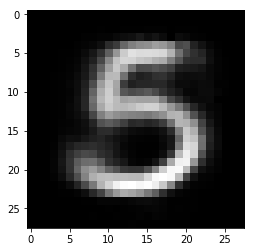

iteration: 46000
D_loss: 0.9559
G_loss: 2.154
()


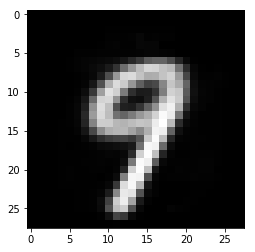

iteration: 47000
D_loss: 0.9698
G_loss: 1.729
()


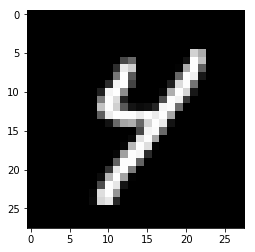

iteration: 48000
D_loss: 0.7852
G_loss: 1.728
()


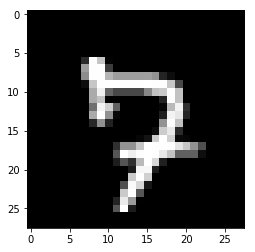

iteration: 49000
D_loss: 0.8925
G_loss: 1.732
()


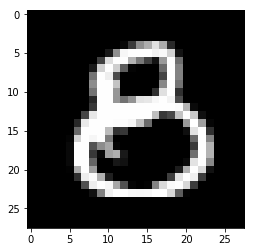

iteration: 50000
D_loss: 0.7887
G_loss: 1.967
()


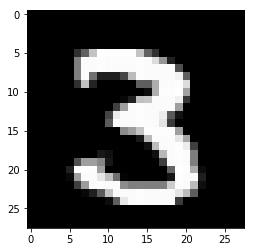

iteration: 51000
D_loss: 0.8452
G_loss: 1.439
()


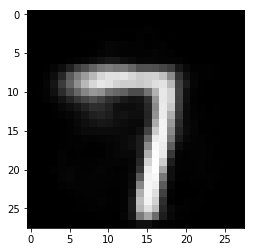

iteration: 52000
D_loss: 0.7664
G_loss: 1.852
()


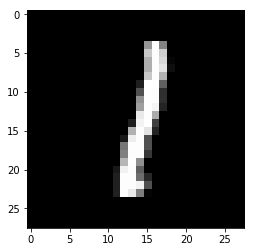

iteration: 53000
D_loss: 1.031
G_loss: 1.813
()


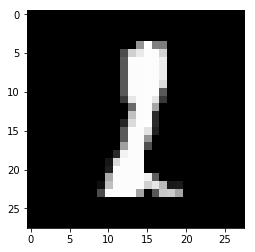

iteration: 54000
D_loss: 1.006
G_loss: 1.762
()


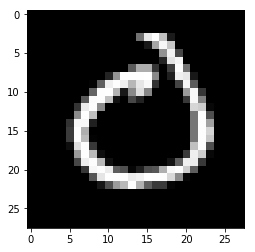

iteration: 55000
D_loss: 0.9076
G_loss: 1.628
()


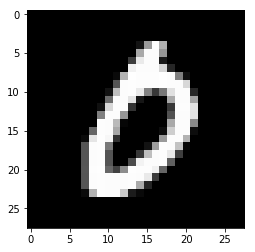

iteration: 56000
D_loss: 0.8442
G_loss: 1.692
()


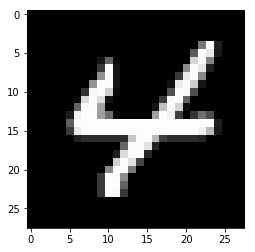

iteration: 57000
D_loss: 0.7555
G_loss: 2.063
()


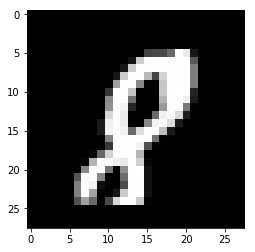

iteration: 58000
D_loss: 0.7594
G_loss: 2.195
()


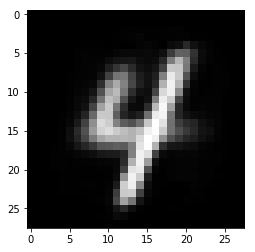

iteration: 59000
D_loss: 0.9099
G_loss: 1.76
()


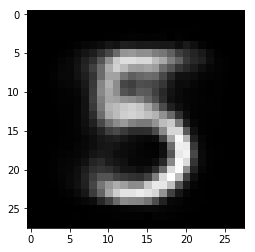

iteration: 60000
D_loss: 1.015
G_loss: 1.942
()


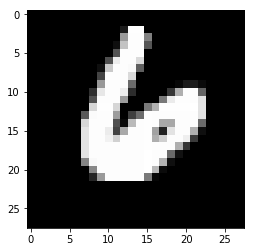

iteration: 61000
D_loss: 0.6531
G_loss: 2.076
()


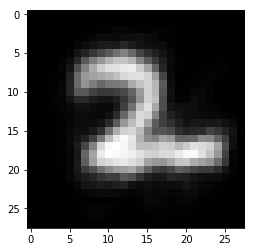

iteration: 62000
D_loss: 0.9321
G_loss: 1.836
()


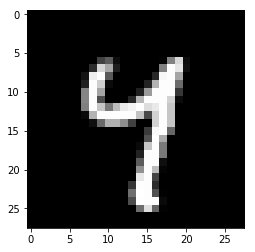

iteration: 63000
D_loss: 0.8931
G_loss: 1.773
()


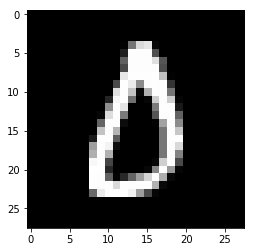

iteration: 64000
D_loss: 0.7287
G_loss: 1.99
()


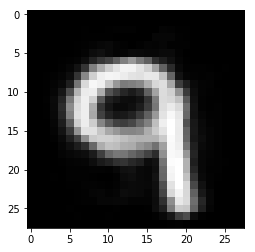

iteration: 65000
D_loss: 0.7009
G_loss: 1.81
()


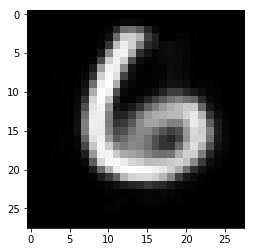

iteration: 66000
D_loss: 0.7532
G_loss: 1.894
()


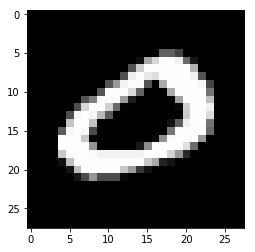

iteration: 67000
D_loss: 0.6282
G_loss: 2.17
()


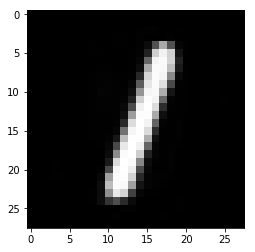

iteration: 68000
D_loss: 0.7542
G_loss: 2.448
()


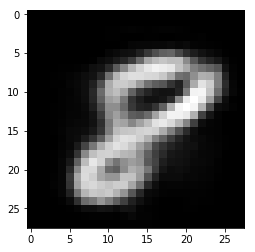

iteration: 69000
D_loss: 0.7594
G_loss: 2.275
()


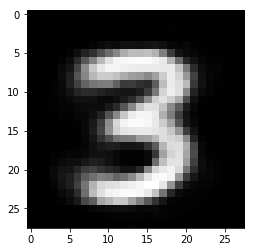

iteration: 70000
D_loss: 0.7142
G_loss: 2.206
()


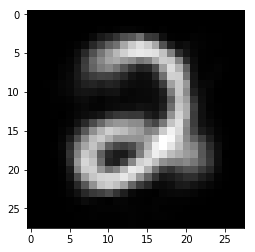

iteration: 71000
D_loss: 0.8168
G_loss: 2.126
()


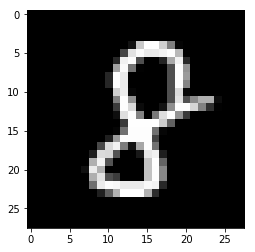

iteration: 72000
D_loss: 0.7355
G_loss: 2.008
()


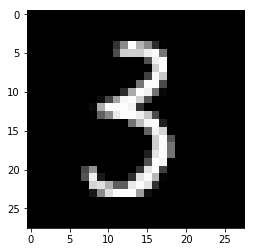

iteration: 73000
D_loss: 0.7752
G_loss: 2.257
()


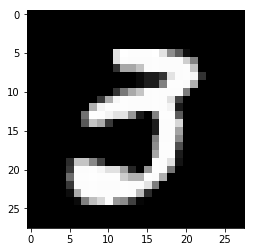

iteration: 74000
D_loss: 0.7559
G_loss: 2.488
()


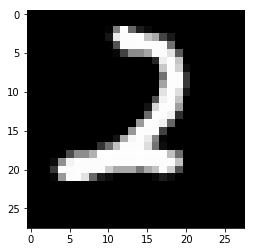

iteration: 75000
D_loss: 0.8305
G_loss: 2.406
()


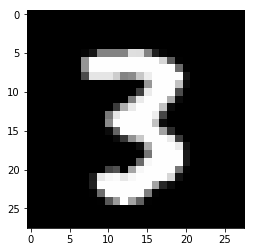

iteration: 76000
D_loss: 0.6786
G_loss: 2.542
()


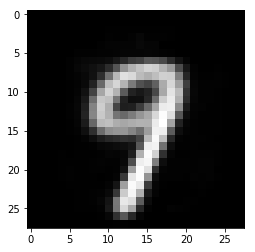

iteration: 77000
D_loss: 0.7281
G_loss: 2.273
()


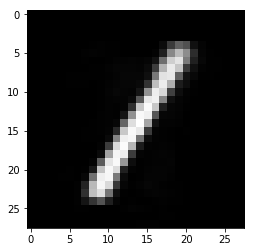

iteration: 78000
D_loss: 0.7114
G_loss: 2.301
()


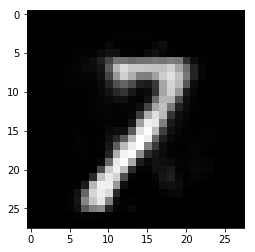

iteration: 79000
D_loss: 0.7336
G_loss: 2.219
()


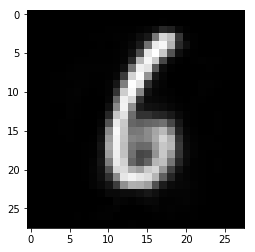

iteration: 80000
D_loss: 0.7358
G_loss: 2.463
()


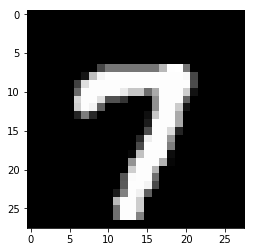

iteration: 81000
D_loss: 0.7522
G_loss: 2.584
()


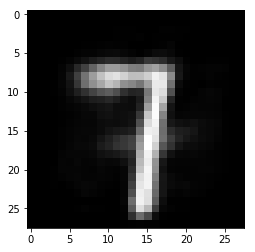

iteration: 82000
D_loss: 0.685
G_loss: 2.454
()


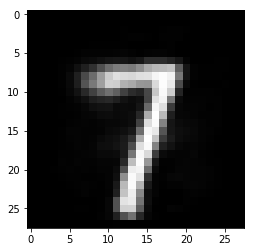

iteration: 83000
D_loss: 0.4713
G_loss: 2.418
()


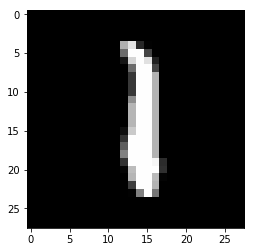

iteration: 84000
D_loss: 0.6058
G_loss: 2.461
()


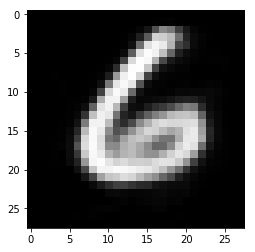

iteration: 85000
D_loss: 0.6324
G_loss: 2.563
()


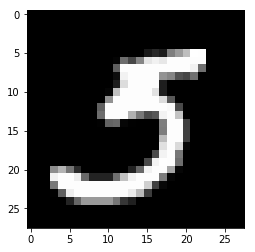

iteration: 86000
D_loss: 0.5416
G_loss: 2.27
()


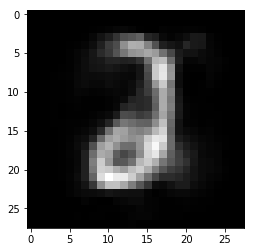

iteration: 87000
D_loss: 0.6775
G_loss: 2.471
()


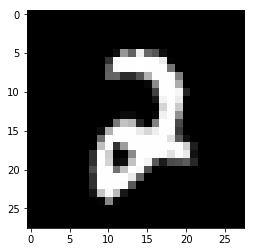

iteration: 88000
D_loss: 0.6642
G_loss: 2.388
()


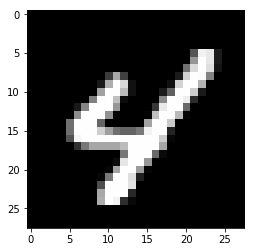

iteration: 89000
D_loss: 0.5726
G_loss: 2.929
()


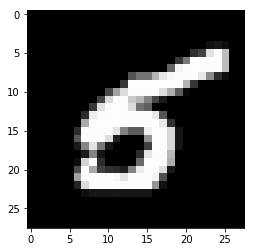

iteration: 90000
D_loss: 0.7729
G_loss: 2.812
()


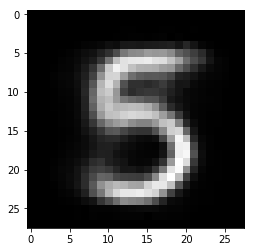

iteration: 91000
D_loss: 0.5115
G_loss: 2.512
()


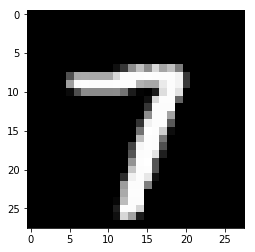

iteration: 92000
D_loss: 0.6075
G_loss: 2.838
()


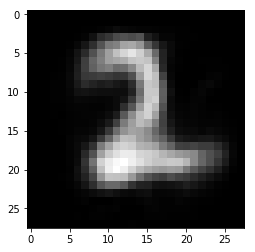

iteration: 93000
D_loss: 0.6363
G_loss: 2.408
()


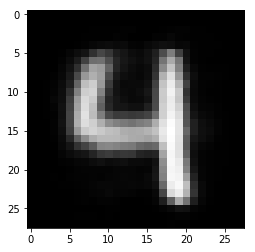

iteration: 94000
D_loss: 0.5827
G_loss: 2.659
()


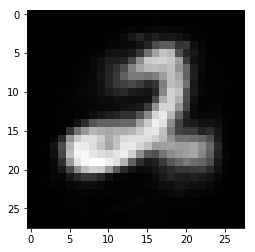

iteration: 95000
D_loss: 0.587
G_loss: 2.664
()


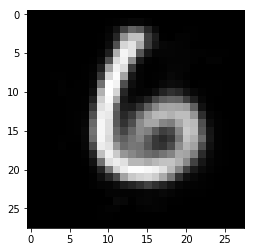

iteration: 96000
D_loss: 0.52
G_loss: 2.611
()


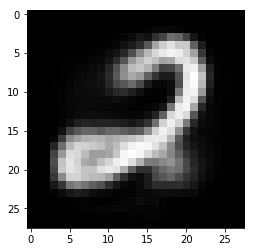

iteration: 97000
D_loss: 0.4948
G_loss: 2.63
()


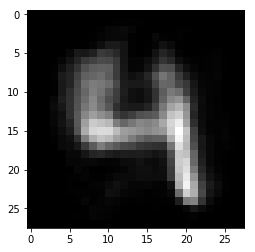

iteration: 98000
D_loss: 0.4732
G_loss: 2.52
()


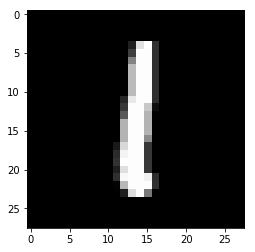

iteration: 99000
D_loss: 0.4932
G_loss: 2.737
()


In [55]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 128
# the dimension of the random samples
z_dim = 100
result_freq = 1000
# plot generators' output every figure_iter step
figure_iter = 1000
max_iter = 100000
size1 = 5
size2 = 5
i = 0
img = generate_data(mnist.train.images[:5000])
for iter in range(max_iter):
    
    if iter % figure_iter == 0:
        
        # G_sample is a sample from the generator
        samples = sess.run(G_sample, feed_dict={Z: sample_z(size1*size2, z_dim)})

        fig1 = plot_sample(samples, size1, size2)
        plt.savefig(output_dir + 'GANs' + str(i) + '.png', bbox_inches='tight')
        i += 1
        plt.close(fig1)

    batch_xs = next_batch(img,batch_size)
    
    _, discriminator_loss = sess.run([D_solver, D_loss], feed_dict={X: batch_xs, Z: sample_z(batch_size, z_dim)})
    _, generator_loss     = sess.run([G_solver, G_loss], feed_dict={Z: sample_z(batch_size, z_dim)})

    if iter % result_freq == 0:
        first_image = batch_xs[0]
        first_image = np.array(first_image, dtype='float')
        pixels = first_image.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.show()
        print('iteration: {}'.format(iter))
        print('D_loss: {:0.4}'.format(discriminator_loss))
        print('G_loss: {:0.4}'.format(generator_loss))
        print()